<b>I. INTRODUCTION</b>

<b>Goal:</b> The goal of the project is to classify different physical activities basing on tri-axial smartphone accelerometer data. 

<b>Input data:</b> consists of two files: 
- <i>train_time_series.csv</i> with raw accelerometer data from  Beiwe research platform; format: <i>timestamp, UTC time, accuracy, x, y, z</i> where <i>x,y,z</i> correspond to measurements of acceleration along axes;
- <i>train_labels.csv</i>  contains the activity labels such as: 1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up; format: <i>timestamp, UTC time, label</i> 

<b>Unlabelled data (for predictions):</b> consist of two files:
- <i>test_time_series.csv</i>
- <i>test_labels.csv</i>
which have same format as input data apart from the labels

<b>Key steps</b>:
- Data loading and exploration
- Data cleaning and merging input tables
- Data transformation
- Construction of various models and hyperparameter selection
- Model performance benchmarking
- Choice of the best model
- Final prediction of unalbelled dataset

<b>II. METHODS</b>

<b>1. Loading data: </b>In first step I load the following files to pandas DataFrame:
- <i>df_labels</i> from <i>train_labels.csv</i> file
- <i>df_time_series<i> from <i>train_time_series.csv</i> file.

<b>2. Data exploration/cleaning</b>: I checked if there is any data to clean (not valid for data prossesing). I used pandas <i>isnull()</i> for every value in both dataframes. I checked also if all indices from labels exist in time_series data frame.There are no  missing values in the datasets.
    
<b>3. Data visualisation</b>: a) I plot data from all three axis for all data set. b) Then I plot data from activities examples to check the diffrence beetweenen them. Conclusions are listed below plots. 
    
<b>4. Combining input data frames:</b> I merged input data containing time series and labels in order to use them for building the model. I added 30 columns to df_labels which represent accelerometr tri-axial values from df_time_series from previous 10 observations $x(t), y(t), z(t), \dots x(t-9), y(t-9), z(t-9)$.
    
<b>5. Data transformation</b>: 
- a) to smoothen data from columns $x(t), y(t), z(t), \dots x(t-9), y(t-9), z(t-9)$ I calculated average of these values along every axis for every labeled observation. Added additional columns `meanx, meany, meanz` for to be used in the model.
- b) since the classes in the dataset are quite inbalanced (there majority of observations belongs to `walking (2)` activity) I reduced the number of such observations to avoid overfitting
    
<b>6. Dividing input data into test and training samples</b> - I split input data into training and test samples to to evaluate each models' performance
    
<b>7. Building simple KNN model</b> treated as reference method.
    
<b>8. Building basic random forest model</b> to achive better accuracy than KNN.
    
<b>9. Finding best hyperparameters</b> to imporove accuracy of random forest predictions.
    
<b>10. Building model on the whole input data and applying model to predictions of the unlabeled dataset (<i>test_time_series.csv</i>,<i>test_labels.csv</i>)</b>

    


<b>III. RESULT</b> presents in the code bellow

In [1]:
#Libraries import
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import validation_curve
import time, datetime

import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<b>1. Data loading</b>

In [2]:
df_labels = pd.read_csv('https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+1T2020+type@asset+block/train_labels.csv', index_col = 0)
df_time_series = pd.read_csv('https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+1T2020+type@asset+block/train_time_series.csv', index_col = 0)

<b>Data exploration</b>

In [3]:
df_labels.head()

,timestamp,UTC time,label
20589,1565109931087,2019-08-06T16:45:31.087,1
20599,1565109932090,2019-08-06T16:45:32.090,1
20609,1565109933092,2019-08-06T16:45:33.092,1
20619,1565109934094,2019-08-06T16:45:34.094,1
20629,1565109935097,2019-08-06T16:45:35.097,1


In [4]:
df_time_series.head()

,timestamp,UTC time,accuracy,x,y,z
20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450


<b>2. Data exploration/cleaning</b>


In [5]:
print('Any NaN values in df_labels: ', pd.isnull(df_labels).values.any())
print('Any NaN values in df_time_series: ', pd.isnull(df_time_series).values.any())

# Checking if all indexes from labels have respective timestamps

print('All indices from df_labels are in df_time_series: ', df_labels.index.isin(df_time_series.index).all())

Any NaN values in df_labels:  False
Any NaN values in df_time_series:  False
All indices from df_labels are in df_time_series:  True


<b>3a. Data visualisation</b>

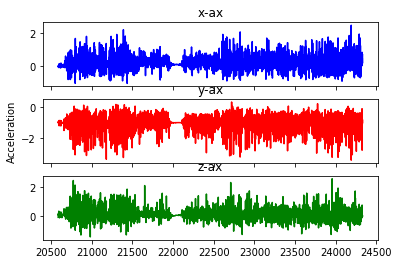

In [6]:
fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(df_time_series.x, color='blue')
axs[0].set_title('x-ax')
axs[1].plot(df_time_series.y, color='red')
axs[1].set_title('y-ax')
axs[1].set_ylabel("Acceleration")
axs[2].plot(df_time_series.z, color='green')
axs[2].set_title('z-ax')
plt.show()

<b>Conclusion</b>: data along all three axes seems to have some similarities. This plot also shows that some activities have narrower acceleration than other. Lets explore data in examples of activities.

<b>3b. Data exploration and visualisation for diffrent activities</b>

In [7]:
# Subseting indices corresponding to standing and stair-up activities
print(df_labels[df_labels.label == 1].head())
print(df_labels[df_labels.label == 4].head())

           timestamp                 UTC time  label
20589  1565109931087  2019-08-06T16:45:31.087      1
20599  1565109932090  2019-08-06T16:45:32.090      1
20609  1565109933092  2019-08-06T16:45:33.092      1
20619  1565109934094  2019-08-06T16:45:34.094      1
20629  1565109935097  2019-08-06T16:45:35.097      1
           timestamp                 UTC time  label
21559  1565110028310  2019-08-06T16:47:08.310      4
21569  1565110029312  2019-08-06T16:47:09.312      4
21579  1565110030314  2019-08-06T16:47:10.314      4
21589  1565110031316  2019-08-06T16:47:11.316      4
21599  1565110032319  2019-08-06T16:47:12.319      4


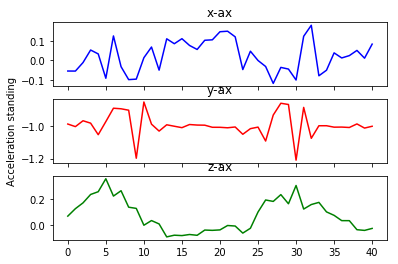

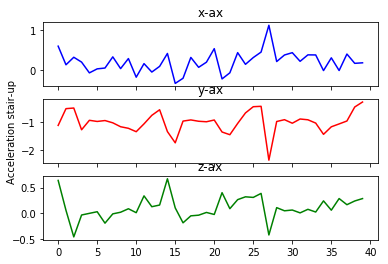

In [8]:
standing = list(range(20589,20630))
fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(list(df_time_series.loc[standing, 'x']), color='blue')
axs[0].set_title('x-ax')
axs[1].plot(list(df_time_series.loc[standing, 'y']), color='red')
axs[1].set_title('y-ax')
axs[1].set_ylabel("Acceleration standing")
axs[2].plot(list(df_time_series.loc[standing, 'z']), color='green')
axs[2].set_title('z-ax')
plt.show()

stair_up = list(range(21559,21599))
fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(list(df_time_series.loc[stair_up, 'x']), color='blue')
axs[0].set_title('x-ax')
axs[1].plot(list(df_time_series.loc[stair_up, 'y']), color='red')
axs[1].set_title('y-ax')
axs[1].set_ylabel("Acceleration stair-up")
axs[2].plot(list(df_time_series.loc[stair_up, 'z']), color='green')
axs[2].set_title('z-ax')
plt.show()

<b>Conclusion</b>: the diffrence beetween those two activities is significant mostly in z-ax

<b>4. Combining input data frames</b>

In [9]:
df_alt = df_labels.copy()

label_range = list(range(-10,0))

# Adding rows with np.nan values to handle index errors. 
# Iteration starts from -10, so I have to add few rows before first indes index in df_time_series 
df_time_series.loc[20579] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
df_time_series.loc[20580] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
df_time_series.loc[20581] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
df_time_series.loc[20582] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
df_time_series.loc[20583] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
df_time_series.loc[20584] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
df_time_series.loc[20585] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

# Adding 30 columns to df_labels which represent accelerometr tri-axial values from df_time_series based on 10 earlier observations
df_label_indices = list(df_labels.index)
for i in df_label_indices:
    for j in label_range:
        df_alt.loc[i, 'x' + str(j)[1:]] = df_time_series.loc[i + j, 'x']
        df_alt.loc[i, 'y' + str(j)[1:]] = df_time_series.loc[i + j, 'y']
        df_alt.loc[i, 'z' + str(j)[1:]] = df_time_series.loc[i + j, 'z']

In [10]:
df_alt.head()

,timestamp,UTC time,label,x10,y10,z10,x9,y9,z9,x8,...,z4,x3,y3,z3,x2,y2,z2,x1,y1,z1
20589,1565109931087,2019-08-06T16:45:31.087,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.006485,-0.934860,-0.069046,-0.066467,-1.015442,0.089554,-0.043488,-1.021255,0.178467
20599,1565109932090,2019-08-06T16:45:32.090,1,-0.053802,-0.987701,0.068985,-0.054031,-1.003616,0.126450,-0.010880,...,0.223221,-0.031784,-0.893982,0.264236,-0.097427,-0.902725,0.137680,-0.094864,-1.197876,0.128494
20609,1565109933092,2019-08-06T16:45:33.092,1,0.013718,-0.852371,-0.000870,0.067947,-0.988525,0.034973,-0.049255,...,-0.072174,0.055618,-0.994019,-0.078293,0.102280,-0.994797,-0.038040,0.104599,-1.007675,-0.040253
20619,1565109934094,2019-08-06T16:45:34.094,1,0.145584,-1.007843,-0.036819,0.148285,-1.010757,-0.003036,0.119675,...,0.193161,-0.116592,-0.932434,0.182114,-0.035355,-0.860016,0.234421,-0.043869,-0.867630,0.164062
20629,1565109935097,2019-08-06T16:45:35.097,1,-0.099380,-1.209686,0.304489,0.122498,-0.885483,0.123444,0.178406,...,0.034439,0.024414,-1.008957,0.034195,0.050781,-0.987045,-0.035294,0.011429,-1.012543,-0.040665


<b>5a. Data transformation</b> - added mean

In [11]:
# There is data missing (np.nan) in the first row of df_lab, dropping it
df_alt.drop(20589, inplace = True)

# All further calculation will be performedn df_alt which are based on merged data from labels and time series

# Calculate mean, standard deviation and length of movement vectors. 

df_alt['meanx'] = df_alt[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']].mean(axis=1)
df_alt['meany'] = df_alt[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']].mean(axis=1)
df_alt['meanz'] = df_alt[['z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10']].mean(axis=1)

df_alt['len1'] = (df_alt.x1 ** 2 + df_alt.y1 ** 2 + df_alt.z1 ** 2) ** (1/2)
df_alt['len2'] = (df_alt.x2 ** 2 + df_alt.y2 ** 2 + df_alt.z2 ** 2) ** (1/2)
df_alt['len3'] = (df_alt.x3 ** 2 + df_alt.y3 ** 2 + df_alt.z3 ** 2) ** (1/2)
df_alt['len4'] = (df_alt.x4 ** 2 + df_alt.y4 ** 2 + df_alt.z4 ** 2) ** (1/2)
df_alt['len5'] = (df_alt.x5 ** 2 + df_alt.y5 ** 2 + df_alt.z5 ** 2) ** (1/2)
df_alt['len6'] = (df_alt.x6 ** 2 + df_alt.y6 ** 2 + df_alt.z6 ** 2) ** (1/2)
df_alt['len7'] = (df_alt.x7 ** 2 + df_alt.y7 ** 2 + df_alt.z7 ** 2) ** (1/2)
df_alt['len8'] = (df_alt.x8 ** 2 + df_alt.y8 ** 2 + df_alt.z8 ** 2) ** (1/2)
df_alt['len9'] = (df_alt.x9 ** 2 + df_alt.y9 ** 2 + df_alt.z9 ** 2) ** (1/2)
df_alt['len10'] = (df_alt.x10 ** 2 + df_alt.y10 ** 2 + df_alt.z10 ** 2) ** (1/2)

df_alt['x_std'] = df_alt[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']].std(axis=1)
df_alt['y_std'] = df_alt[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']].std(axis=1)
df_alt['z_std'] = df_alt[['z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10']].std(axis=1)

<b>5b. Data transformation</b> - reduce inbalace in data

In [12]:
# Data is inbalanced (too many walking(2) activity in data)
df_alt.label.value_counts()

2    213
3     88
4     47
1     26
Name: label, dtype: int64

In [13]:
# Reduce walking activity
 
# Activities diffrent than walking
df_maj = df_alt[df_alt.label!=2]

# Walking activities
df_min = df_alt[df_alt.label==2]
 
# Resampling data
df_min_upsampled = resample(df_min, replace=True, n_samples=100, random_state=0)
df_upsampled = pd.concat([df_maj, df_min_upsampled])

df_alt = df_upsampled.copy()

In [14]:
# Dataset is more balanced
df_alt.label.value_counts()

2    100
3     88
4     47
1     26
Name: label, dtype: int64

<b>6. Dividing input data into test and training samples</b>

In [15]:
# Splitted data
X_train, X_test, y_train, y_test = train_test_split(df_alt[df_alt.columns[3:]], df_alt['label'], test_size=0.25, random_state=0)

# Covariates and classification outcome
classification_outcome = df_alt['label']
covariates = df_alt[df_alt.columns[3:]]

<b>7. Building simple KNN model and selecting hyperparameter for KNN

In [16]:
# Function to test accuracy of predictions compared to outcomes
def accuracy(pred, out):
    vl1=0
    for i in range(len(pred)):
        if pred[i] == out[i]:
            vl1+=1
    return (vl1/len(pred)*100)

In [17]:
# Function to built KNN and return accuracy of predictions
def knn_labeling(lab, n_neigh):
    num_data = lab[lab.columns[3:]]
    knn = KNeighborsClassifier(n_neighbors = n_neigh)
    knn.fit(num_data, lab['label'])
    predictions = knn.predict(num_data)
    return accuracy(list(predictions), list(lab["label"]))

In [18]:
# Hyperparameter selection for KNN in range of 2 to 15 neighbors
accuracy_lab1= [knn_labeling(df_alt, x) for x in range(2,15)]
accuracy_lab1

[77.39463601532567,
 77.01149425287356,
 71.26436781609196,
 67.81609195402298,
 67.04980842911877,
 65.13409961685824,
 64.75095785440614,
 64.75095785440614,
 62.83524904214559,
 63.2183908045977,
 60.15325670498084,
 56.70498084291188,
 54.02298850574713]

In [19]:
# Cross-validation for KNN (number of neighbours = 2)
knn = KNeighborsClassifier(n_neighbors = 2)
knn_scores = cross_val_score(knn, covariates, classification_outcome,  cv=20)
print("Cross-validation accuracy for the KNN method: %0.2f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))

# Fitting the model
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

# Accuracy of test data for the best hyperparameter selection 
print("The test data accuracy for the KNN method: ", accuracy(list(predictions), list(y_test))/100)

Cross-validation accuracy for the KNN method: 0.56 (+/- 0.25)
The test data accuracy for the KNN method:  0.5


<b>Conclusion</b>: KNN was able to predict correct values for the test data with accuracy 50%. The mean score from cross-validation is around 56%. It's good idea to try another model.

<b>8. Building random forest model</b>

In [20]:
# Build random forest model on splited input data (train, test)
# Using some specific hyperparameters which will be fine-tuned in next steps

forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)

In [21]:
forest_regression_scores = cross_val_score(forest_classifier, covariates, classification_outcome,  cv=20)
print("Cross-validation accuracy for the random forest model: %0.2f (+/- %0.2f)" % (forest_regression_scores.mean(), forest_regression_scores.std() * 2))

Cross-validation accuracy for the random forest model: 0.60 (+/- 0.18)


In [22]:
# Acuracy predictions for random forest
pred = list(forest_classifier.fit(X_train, y_train).predict(X_test))
print("The test data accuracy for the random forest model: ", accuracy(pred, list(y_test))/100)

The test data accuracy for the random forest model:  0.5757575757575758


<b>Conclusion</b>: Random forest has better accuracy than KNN but we can try to find better hyperparameter

<b>9. Finding best hyperparameters</b> to imporove accuracy of random forest predictions

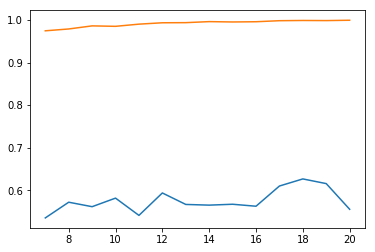

In [23]:
# Finding best value of n_estimators hyperparameter

np.random.seed(0)
num_est = [7,8,9, 10,11, 12, 13, 14,15, 16, 17, 18, 19, 20]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv=20)


plt.plot(num_est, list(np.mean(test_scoreNum, axis=1)))
plt.plot(num_est, list(np.mean(train_scoreNum, axis=1)))


plt.show()

The highest accuracy is obtained for n_estimators = 12 or 18

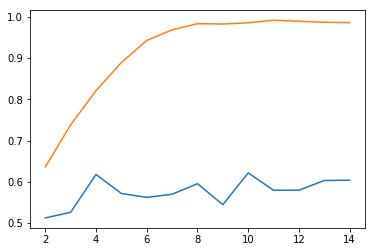

In [24]:
# Finding the best value of max_depth hyperparameter
np.random.seed(0)
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
train_scoreNum1, test_scoreNum1 = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = max_depth, cv = 20)

plt.plot(max_depth, list(np.mean(test_scoreNum1, axis=1)))
plt.plot(max_depth, list(np.mean(train_scoreNum1, axis=1)))

plt.show()

The highest accuracy is obtained for max_depth = 10

In [25]:
forest_classifier1 = RandomForestClassifier(n_estimators = 12, max_depth=10, random_state=0)
forest_regression_scores1 = cross_val_score(forest_classifier1, covariates, classification_outcome,  cv=20)

print("Cross-validation accuracy for the random forest model with n_estimators = 12 and max_depth=10: %0.2f (+/- %0.2f)" % (forest_regression_scores1.mean(), forest_regression_scores1.std() * 2))

Cross-validation accuracy for the random forest model with n_estimators = 12 and max_depth=10: 0.66 (+/- 0.24)


In [26]:
forest_classifier2 = RandomForestClassifier(n_estimators = 18, max_depth=10, random_state=0)
forest_regression_scores2 = cross_val_score(forest_classifier2, covariates, classification_outcome,  cv=20)

print("Cross-validation accuracy for the random forest model with n_estimators = 18 and max_depth=10: %0.2f (+/- %0.2f)" % (forest_regression_scores2.mean(), forest_regression_scores2.std() * 2))

Cross-validation accuracy for the random forest model with n_estimators = 18 and max_depth=10: 0.64 (+/- 0.25)


In [27]:
# Applying forest with the best hyperparameters
pred = list(forest_classifier1.fit(X_train, y_train).predict(X_test))

print('The test data accuracy for the random forest model with improved hyperparameters: ', accuracy(pred, list(y_test))/100)

The test data accuracy for the random forest model with improved hyperparameters:  0.6515151515151516


<b>Conclusion</b>: After improving hyperparameters the mean score from cross-validation is higher - 66%. Standard deviation from cross-validation is quite high which means that predictions wouldn't be stable. The solution could be to built model on larger data set.

<b>10. Building model on the whole input data and applying model to obtain predictions for the unlabeled dataset (<i>test_time_series.csv</i>,<i>test_labels.csv</i>)</b>

In [28]:
from datetime import datetime
first_t = datetime.now() # for run time evaluation

X_real = pd.read_csv('https://courses.edx.org/assets/courseware/v1/1ca4f3d4976f07b8c4ecf99cf8f7bdbc/asset-v1:HarvardX+PH526x+1T2020+type@asset+block/test_time_series.csv', index_col = 0)

df_real = pd.read_csv('https://courses.edx.org/assets/courseware/v1/72d5933c310cf5eac3fa3f28b26d9c39/asset-v1:HarvardX+PH526x+1T2020+type@asset+block/test_labels.csv', index_col = 0)

# Adding rows with np.nan values to handle the index errors - same as in input data
X_real.loc[24329] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

df_label_indices = list(df_real.index)
for i in df_label_indices:
    for j in label_range:
        df_real.loc[i, 'x' + str(j)[1:]] = X_real.loc[i + j, 'x']
        df_real.loc[i, 'y' + str(j)[1:]] = X_real.loc[i + j, 'y']
        df_real.loc[i, 'z' + str(j)[1:]] = X_real.loc[i + j, 'z']

In [29]:
# Data transformation  - same steps as data transformation in input data

# To predict first index we have to fill np.nan with some value
df_real.fillna(0, inplace = True)
df_real['meanx'] = df_real[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']].mean(axis=1)
df_real['meany'] = df_real[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']].mean(axis=1)
df_real['meanz'] = df_real[['z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10']].mean(axis=1)

df_real['len1'] = (df_real.x1 ** 2 + df_real.y1 ** 2 + df_real.z1 ** 2) ** (1/2)
df_real['len2'] = (df_real.x2 ** 2 + df_real.y2 ** 2 + df_real.z2 ** 2) ** (1/2)
df_real['len3'] = (df_real.x3 ** 2 + df_real.y3 ** 2 + df_real.z3 ** 2) ** (1/2)
df_real['len4'] = (df_real.x4 ** 2 + df_real.y4 ** 2 + df_real.z4 ** 2) ** (1/2)
df_real['len5'] = (df_real.x5 ** 2 + df_real.y5 ** 2 + df_real.z5 ** 2) ** (1/2)
df_real['len6'] = (df_real.x6 ** 2 + df_real.y6 ** 2 + df_real.z6 ** 2) ** (1/2)
df_real['len7'] = (df_real.x7 ** 2 + df_real.y7 ** 2 + df_real.z7 ** 2) ** (1/2)
df_real['len8'] = (df_real.x8 ** 2 + df_real.y8 ** 2 + df_real.z8 ** 2) ** (1/2)
df_real['len9'] = (df_real.x9 ** 2 + df_real.y9 ** 2 + df_real.z9 ** 2) ** (1/2)
df_real['len10'] = (df_real.x10 ** 2 + df_real.y10 ** 2 + df_real.z10 ** 2) ** (1/2)

df_real['x_std'] = df_real[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']].std(axis=1)
df_real['y_std'] = df_real[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']].std(axis=1)
df_real['z_std'] = df_real[['z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10']].std(axis=1)

In [30]:
# Building random forest for the whole dataset
classification_outcome = df_alt['label']
covariates = df_alt[df_alt.columns[3:]]
forest_classifier = RandomForestClassifier(n_estimators = 12, max_depth=10, random_state=0)

pred = list(forest_classifier.fit(covariates, classification_outcome).predict(df_real[df_real.columns[3:]]))

sec_t = datetime.now()

In [31]:
print('length of predictions: ' + str(len(pred)))
print(pred)
pd.DataFrame(pred).to_csv('label_predictions.csv', index = False, header=False )
print('time: ' + str(sec_t - first_t))

length of predictions: 125
[2, 3, 3, 4, 3, 3, 3, 3, 2, 4, 2, 4, 3, 1, 2, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 3, 3, 4, 3, 4, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 4, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2]
time: 0:00:03.787781


<b>IV CONSLUSION</b> 

As expected the random forest proved to give more accurate predictions than KNN. It is possible to achive better prediction accuracy by providing more spohisticated features obtained from tri-axial data probably with some expert-based knowledge from the field. Perhaps better results could be achieved by builing model on larger data set.